In [2]:
import json

    
def construct_fileset():

    # list of files
    with open("ntuples.json") as f:
        file_info = json.load(f)

    # process into "fileset" summarizing all info
    fileset = {}
    for process in file_info.keys():
        if process == "data":
            continue  # skip data

        for variation in file_info[process].keys():
            file_list = file_info[process][variation]["files"]
            file_path = file_list[0]["path"]
            fileset.update({process:file_path})

    return fileset


In [3]:
fileset = construct_fileset()
print(fileset)

{'ttbar': 'https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/TT_TuneEE5C_13TeV-powheg-herwigpp/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12-v1/10000/00284D8E-E8DB-E511-A462-02163E012D21.root', 'single_top_s_chan': 'https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/ST_s-channel_4f_InclusiveDecays_13TeV-amcatnlo-pythia8/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12-v1/00000/0EB5E88C-FE0D-E611-915D-003048FFD76C.root', 'single_top_t_chan': 'https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/ST_t-channel_antitop_4f_inclusiveDecays_13TeV-powhegV2-madspin-pythia8_TuneCUETP8M1/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asymptotic_v12-v1/00000/00004F9A-E3D2-E511-ABEC-0CC47A78A478.root', 'single_top_tW': 'https://xrootd-local.unl.edu:1094//store/user/AGC/datasets/RunIIFall15MiniAODv2/ST_tW_antitop_5f_inclusiveDecays_13TeV-powheg-pythia8_TuneCUETP8M1/MINIAODSIM/PU25nsData2015v1_76X_mcRun2_asympto

In [4]:
fileset.keys()

dict_keys(['ttbar', 'single_top_s_chan', 'single_top_t_chan', 'single_top_tW', 'wjets'])

In [5]:
from coffea.nanoevents import transforms
from coffea.nanoevents.methods import base, vector
from coffea.nanoevents.schemas.base import BaseSchema, zip_forms

class AGCSchema(BaseSchema):
    def __init__(self, base_form):
        super().__init__(base_form)
        self._form["contents"] = self._build_collections(self._form["contents"])

    def _build_collections(self, branch_forms):
        names = set([k.split('_')[0] for k in branch_forms.keys() if not (k.startswith('number'))])
        # Remove n(names) from consideration. It's safe to just remove names that start with n, as nothing else begins with n in our fields.
        # Also remove GenPart, PV and MET because they deviate from the pattern of having a 'number' field.
        names = [k for k in names if not (k.startswith('n') | k.startswith('met') | k.startswith('GenPart') | k.startswith('PV'))]
        output = {}
        for name in names:
            offsets = transforms.counts2offsets_form(branch_forms['number' + name])
            content = {k[len(name)+1:]: branch_forms[k] for k in branch_forms if (k.startswith(name + "_") & (k[len(name)+1:] != 'e'))}
            # Add energy separately so its treated correctly by the p4 vector.
            content['energy'] = branch_forms[name+'_e']
            # Check for LorentzVector
            output[name] = zip_forms(content, name, 'PtEtaPhiELorentzVector', offsets=offsets)

        # Handle GenPart, PV, MET. Note that all the nPV_*'s should be the same. We just use one.
        output['met'] = zip_forms({k[len('met')+1:]: branch_forms[k] for k in branch_forms if k.startswith('met_')}, 'met')
        #output['GenPart'] = zip_forms({k[len('GenPart')+1:]: branch_forms[k] for k in branch_forms if k.startswith('GenPart_')}, 'GenPart', offsets=transforms.counts2offsets_form(branch_forms['numGenPart']))
        output['PV'] = zip_forms({k[len('PV')+1:]: branch_forms[k] for k in branch_forms if (k.startswith('PV_') & ('npvs' not in k))}, 'PV', offsets=transforms.counts2offsets_form(branch_forms['nPV_x']))
        return output

    @property
    def behavior(self):
        behavior = {}
        behavior.update(base.behavior)
        behavior.update(vector.behavior)
        return behavior

In [12]:
# xsec_info = {
#     "ttbar": 396.87 + 332.97, # nonallhad + allhad, keep same x-sec for all
#     "single_top_s_chan": 2.0268 + 1.2676,
#     "single_top_t_chan": (36.993 + 22.175)/0.252,  # scale from lepton filter to inclusive
#     "single_top_tW": 37.936 + 37.906,
#     "wjets": 61457 * 0.252,  # e/mu+nu final states
#     "data": None
# }

from coffea.nanoevents import NanoEventsFactory
def construct_eventset(fileset):
    eventset = {}
    for process in fileset.keys():
        events = NanoEventsFactory.from_root(
                                            file=fileset[process],
                                            schemaclass=AGCSchema,
                                            treepath="events"
                                            ).events()
        eventset.update({process:events})
    return eventset
        

In [24]:
import awkward as ak
import numpy as np

def fill(histogram, process, events):

    variation = "nominal"

    # normalization for MC
    x_sec = xsec_info[process]
    nevts_total = len(events)
    lumi = 3378 # /pb
    xsec_weight = x_sec * lumi / nevts_total



    ### event selection
    # very very loosely based on https://arxiv.org/abs/2006.13076
    # pT > 25 GeV for leptons & jets
    selected_electrons = events.electron[events.electron.pt > 25]
    selected_muons = events.muon[events.muon.pt > 25]
    selected_jets = events.jet[events.jet.pt>25]

    # single lepton requirement
    event_filters = (ak.count(selected_electrons.pt, axis=1) & ak.count(selected_muons.pt, axis=1) == 1)
    # at least four jets
    event_filters = event_filters & (ak.count(selected_jets.pt, axis=1) >= 4)
    # at least one b-tagged jet ("tag" means score above threshold)
    B_TAG_THRESHOLD = 0.5
    event_filters = event_filters & (ak.sum(selected_jets.btag >= B_TAG_THRESHOLD, axis=1) >= 1)

    # apply event filters
    selected_events = events[event_filters]
    selected_electrons = selected_electrons[event_filters]
    selected_muons = selected_muons[event_filters]
    selected_jets = selected_jets[event_filters]

    for region in ["4j1b", "4j2b"]:
        # further filtering: 4j1b CR with single b-tag, 4j2b SR with two or more tags
        if region == "4j1b":
            region_filter = ak.sum(selected_jets.btag >= B_TAG_THRESHOLD, axis=1) == 1
            selected_jets_region = selected_jets[region_filter]
            # use HT (scalar sum of jet pT) as observable
            observable = ak.sum(selected_jets_region.pt, axis=-1)

        elif region == "4j2b":
            region_filter = ak.sum(selected_jets.btag > B_TAG_THRESHOLD, axis=1) >= 2
            selected_jets_region = selected_jets[region_filter]
             # reconstruct hadronic top as bjj system with largest pT
            # the jet energy scale / resolution effect is not propagated to this observable at the moment
            trijet = ak.combinations(selected_jets_region, 3, fields=["j1", "j2", "j3"])  # trijet candidates
            trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3  # calculate four-momentum of tri-jet system
            trijet["max_btag"] = np.maximum(trijet.j1.btag, np.maximum(trijet.j2.btag, trijet.j3.btag))
            trijet = trijet[trijet.max_btag > B_TAG_THRESHOLD]  # require at least one-btag in trijet candidates
            # pick trijet candidate with largest pT and calculate mass of system
            trijet_mass = trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass
            observable = ak.flatten(trijet_mass)



        # nominal pT, but including 2-point systematics
        histogram.fill(
                    observable=observable, region=region, process=process, variation=variation, weight=xsec_weight
                )









In [25]:
import hist
def init():
    num_bins = 25
    bin_low = 50
    bin_high = 550
    name = "observable"
    label = "observable [GeV]"
    histogram = (
            hist.Hist.new.Reg(num_bins, bin_low, bin_high, name=name, label=label)
            .StrCat(["4j1b", "4j2b"], name="region", label="Region")
            .StrCat([], name="process", label="Process", growth=True)
            .StrCat([], name="variation", label="Systematic variation", growth=True)
            .Weight()
    )
    return histogram

In [26]:
histogram = init()
eventset = construct_eventset(fileset)

In [27]:
for process in eventset.keys():
    fill(events=eventset[process], process=process, histogram=histogram)

In [28]:
all_histograms = histogram

In [33]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use("ggplot")
plt.rcParams["axes.facecolor"] = "none"
plt.rcParams["axes.edgecolor"] = "222222"
plt.rcParams["axes.labelcolor"] = "222222"
plt.rcParams["xtick.color"] = "222222"
plt.rcParams["ytick.color"] = "222222"
plt.rcParams["font.size"] = 12
plt.rcParams['text.color'] = "222222"

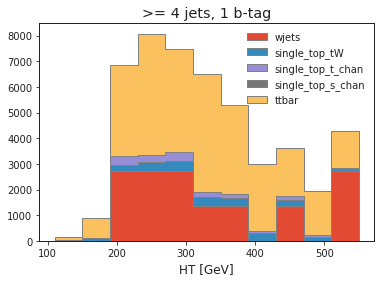

In [34]:
all_histograms[120j::hist.rebin(2), "4j1b", :, "nominal"].stack("process")[::-1].plot(stack=True, histtype="fill", linewidth=1, edgecolor="grey")
plt.legend(frameon=False)

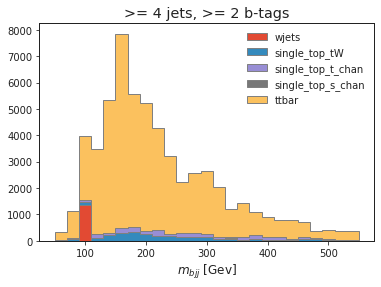

In [38]:
all_histograms[:, "4j2b", :, "nominal"].stack("process")[::-1].plot(stack=True, histtype="fill", linewidth=1,edgecolor="grey")
plt.legend(frameon=False)
plt.title(">= 4 jets, >= 2 b-tags")
plt.xlabel("$m_{bjj}$ [Gev]")
plt.savefig('analysis.png')

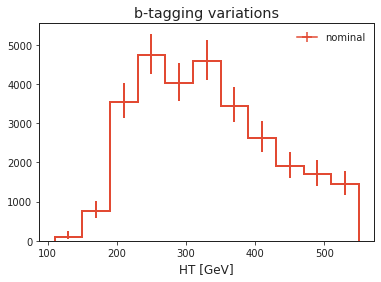

In [36]:
all_histograms[120j::hist.rebin(2), "4j1b", "ttbar", "nominal"].plot(label="nominal", linewidth=2)
plt.legend(frameon=False)
plt.xlabel("HT [GeV]")
plt.title("b-tagging variations");


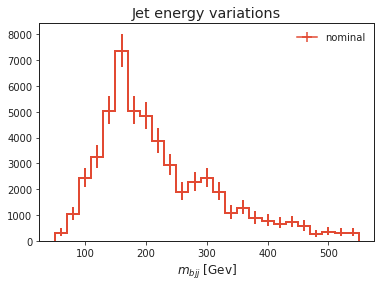

In [37]:
all_histograms[:, "4j2b", "ttbar", "nominal"].plot(label="nominal", linewidth=2)
plt.legend(frameon=False)
plt.xlabel("$m_{bjj}$ [Gev]")
plt.title("Jet energy variations");